In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from gpcsd.gpcsd1d import GPCSD1D
from gpcsd import forward_models, predict_csd
from gpcsd.utility_functions import normalize
from kcsd import KCSD1D
from forward_models import fwd_model_1d, b_fwd_1d
import utility_functions as utils
import rCSD

np.random.seed(0)
utils.use_pdf_plot()

# Two dipoles

generated CSD of shape
(231, 50)


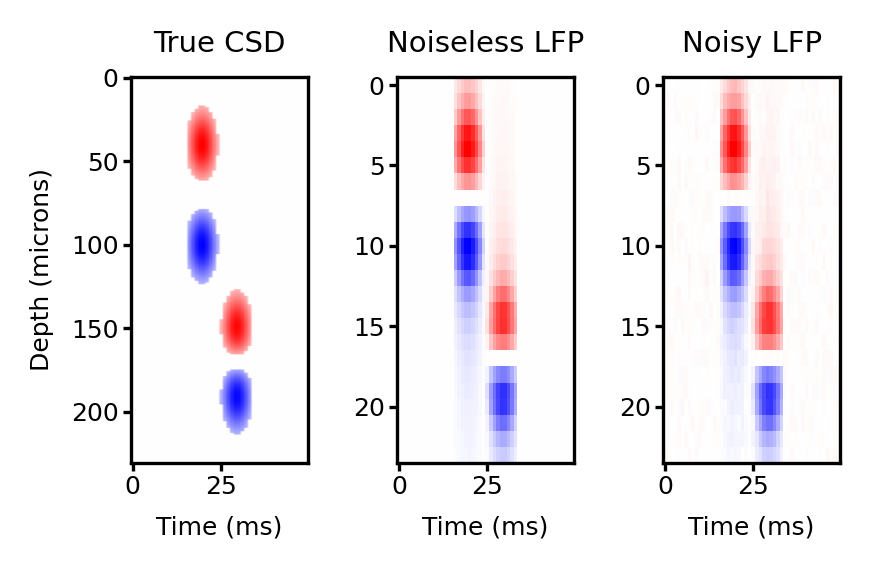

In [141]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""

# %% Functions for CSD pattern and normalization
def csd_true_f(x, t):
    """
    Calculates a toy CSD mean function with two dipoles.
    :param x: desired spatial coordinates (between 0 and 24)
    :param t: desired time coordinates in milliseconds
    :return: (nx, nt) array of values
    """
    # comp1 = np.clip(150 - np.abs(x-200), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp2 = - np.clip(150 - np.abs(x-800), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp3 = np.clip(150 - np.abs(x-1600), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)
    # comp4 = - np.clip(150 - np.abs(x-2200), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)

    comp1 = np.exp(-(x-400)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2)) 
    comp2 = -np.exp(-(x-1000)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2))
    comp3 = np.exp(-(x-1500)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2)) 
    comp4 = -np.exp(-(x-1900)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2))
    val = comp1 + comp2 + comp3 + comp4

    val[np.abs(val) < 3e-1] = 0  # Set small values to zero
    return val/np.max(np.abs(val))

# %% Setup 
a = 0          # Top edge of electrode probe (microns)
b = 2300       # Bottom edge of electrode probe (microns)
R_true = 150   # Radius of cylinder in forward model (microns)
deltaz = 10.0   # Spacing for predictions spatially (microns)
nt = 50        # Number of time points
nx = 24        # Number of observed spatial locations for LFP
snr = 30       # noise characteristics

t = np.linspace(0, 50, nt)[:, None]
x = np.linspace(a, b, nx)[:, None]
nz = int(np.rint(b-a)/deltaz) + 1
z = np.linspace(a, b, nz)[:, None]

# %% Create true CSD
csd_true = csd_true_f(z, t)
print('generated CSD of shape')
print(csd_true.shape)

# %% Create observed LFP
noiseless = normalize(forward_models.fwd_model_1d(csd_true, z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.01, size=(nx, nt))

plt.figure(figsize=(3, 2), dpi=300)
plt.subplot(131)
plt.imshow(csd_true, aspect='auto', cmap='bwr')
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
plt.imshow(noiseless, aspect='auto', cmap='bwr')
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
plt.imshow(lfp, aspect='auto', cmap='bwr')
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()



In [152]:
# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 1.5  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    lfp_smoothed[i,:] = gaussian_filter1d(lfp[i,:], sigma)


### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp[:, :, None]).squeeze()

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=1)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
kcsd = KCSD1D(x, lfp_smoothed, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd = kcsd.values()

### rCSD
lam_smooth = 10
lam_region = 0
lam_lasso = 1e-2
rcsd = rCSD.rCSD(lfp_smoothed[:, :, None], z, x, boundary_depth=[1000, 1500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict()
rcsd.get_difference()

Restarts: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 300.0 0.1778279410038923


Predicting rCSD: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


Difference between old and new rCSD: 0.002117259417419586


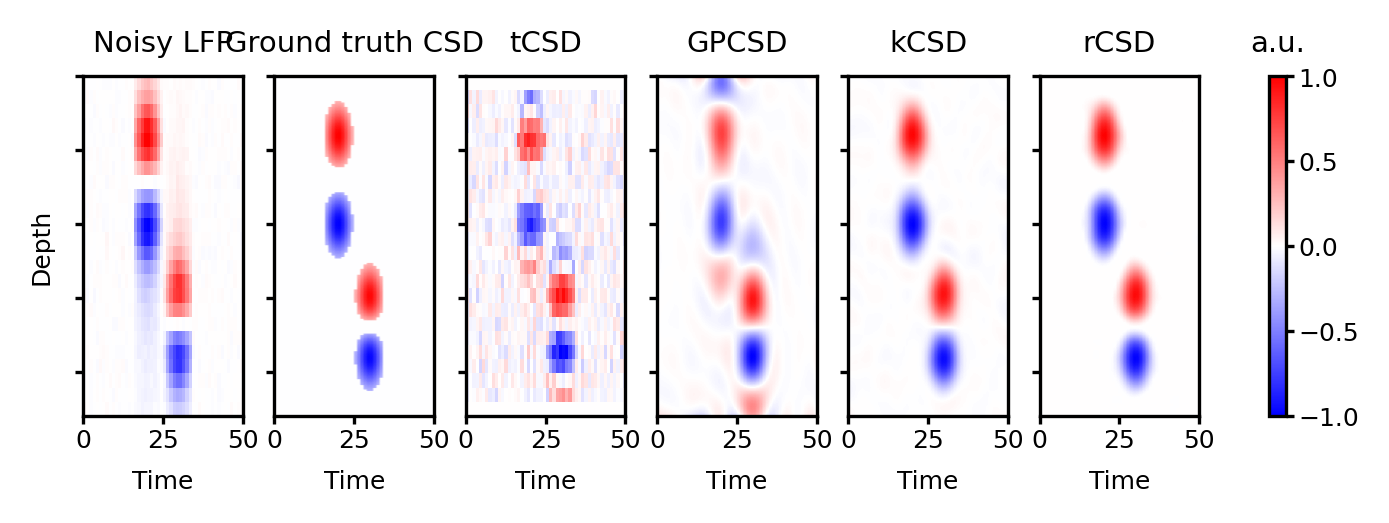

Mean Squared Errors:
tCSD:  0.011684
GPCSD: 0.008370
kCSD:  0.001888
rCSD:  0.001510


In [153]:
# %% Visualize results
cmap = 'bwr'
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true)))

f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp, aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')
axtmp = plt.subplot(162, sharey = ax)
axtmp.set_yticklabels([])

plt.subplot(162, sharey = ax)
plt.imshow(normalize(csd_true), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth CSD')
plt.xlabel('Time')

plt.subplot(163, sharey = ax)
plt.imshow(normalize(tcsd), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time')

plt.subplot(164, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time')

plt.subplot(165, sharey = ax)
im = plt.imshow(normalize(kcsd), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time')

plt.subplot(166, sharey = ax)
im = plt.imshow(normalize(rcsd_pred), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')

clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

# Calculate MSE for each method
true_csd = normalize(csd_true)
true_csd_low_res = true_csd[::10,:]
mse_tcsd = np.mean((normalize(tcsd) - true_csd_low_res) ** 2)
mse_gpcsd = np.mean((normalize(gpcsd.csd_pred.squeeze()) - true_csd) ** 2) 
mse_kcsd = np.mean((normalize(kcsd) - true_csd) ** 2)
mse_rcsd = np.mean((normalize(rcsd_pred.squeeze()) - true_csd) ** 2)

print("Mean Squared Errors:")
print(f"tCSD:  {mse_tcsd:.6f}")
print(f"GPCSD: {mse_gpcsd:.6f}") 
print(f"kCSD:  {mse_kcsd:.6f}")
print(f"rCSD:  {mse_rcsd:.6f}")

# Biophysical ground truth

Biophysical ground truth CSD shape
(89, 101, 1)


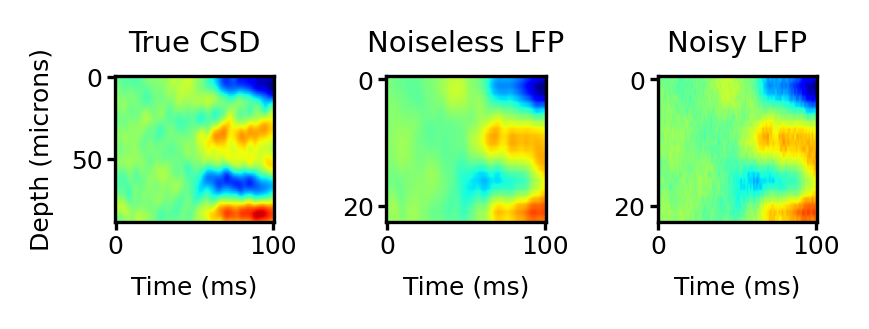

In [292]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""
from scipy.interpolate import interp1d

# %% Setup
deltaz = 10.0   # Spacing for predictions spatially (microns)
deltax = 40.0
R_true = 200   # Radius of cylinder in forward model (microns)
a = 0          # Top edge of electrode probe (microns)
b = 880       # Bottom edge of electrode probe (microns)
nt = 101        # Number of time points
nx = 23        # Number of observed spatial locations for LFP
nz_gt = 23
t_start = 250
t_end = 250 + nt

t = np.linspace(t_start, t_end, nt)[:, None]
x = np.linspace(a, b, nx)[:, None]
z_gt = np.linspace(a, b, nz_gt)[:, None]

# %% Create true CSD
csd_data = np.load('csd_ground_truth.npy', allow_pickle=True).item()
# csd_true_gt = csd_data['all_trials'].transpose([1,2,0])[:nz_gt, t_start:t_end, :]
csd_true_gt = csd_data['trial_avg'][:nz_gt, t_start:t_end, None]

# Interpolate csd_true to make it more dense in spatial dimension
# Create dense spatial grid (4x more dense)
z = np.linspace(z_gt[0,0], z_gt[-1,0], nz_gt*4-3)[:,None]
nz = len(z)
# Interpolate each time point and trial
csd_true = np.zeros((len(z), csd_true_gt.shape[1], csd_true_gt.shape[2]))
for time in range(csd_true.shape[1]):
    for trial in range(csd_true.shape[2]):
        f = interp1d(z_gt.flatten(), csd_true_gt[:,time,trial], kind='cubic')
        csd_true[:,time,trial] = f(z.flatten())


ntrial = csd_true.shape[2]
print('Biophysical ground truth CSD shape')
print(csd_true.shape)


# %% Create observed LFP
noiseless = np.zeros((nx, nt, ntrial))
for itrial in range(ntrial):
    noiseless[:,:,itrial] = normalize(forward_models.fwd_model_1d(csd_true[:,:,itrial], z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.03, size=(nx, nt, ntrial))

plot_trial = 0
plt.figure(figsize=(3, 1.2), dpi=300)
plt.subplot(131)
to_plot = csd_true[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap='jet',
                vmin=-1*maximum, vmax=1*maximum)
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
to_plot = noiseless[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap='jet',
                vmin=-maximum, vmax=maximum)
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
to_plot = lfp[:, :, plot_trial]
maximum = np.max(np.abs(to_plot))
plt.imshow(to_plot, aspect='auto', cmap='jet',
                vmin=-maximum, vmax=maximum)
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()



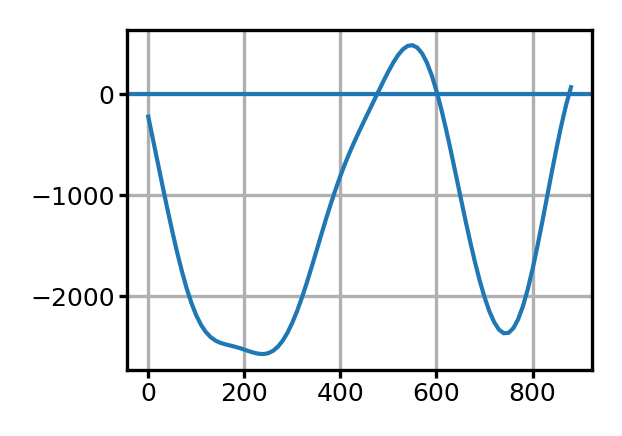

In [200]:
plt.subplots(figsize=(2,1.5), dpi=300)
plt.plot(z, np.cumsum(csd_true.mean(axis=(1,2))))
plt.axhline(0)
plt.grid(True)

In [207]:
# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)

### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=10)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
lfp_flattened = lfp_smoothed.reshape(lfp_smoothed.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd = kcsd.values().reshape((nz, nt, ntrial))

### rCSD
lam_smooth = 5
lam_region = 1e-2
lam_lasso = 1e-2
rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()


Restarts: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 100.0 6.812920690579615


Predicting rCSD: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


In [97]:
# %% Visualize results
plot_trial = 0
cmap = 'jet'
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true[:,:,plot_trial])))

f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')
axtmp = plt.subplot(162, sharey = ax)
axtmp.set_yticklabels([])

plt.subplot(162, sharey = ax)
plt.imshow(normalize(csd_true[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth CSD')
plt.xlabel('Time')

plt.subplot(163, sharey = ax)
plt.imshow(normalize(tcsd[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time')

plt.subplot(164, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time')

plt.subplot(165, sharey = ax)
im = plt.imshow(normalize(kcsd[:,:,plot_trial]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time')

plt.subplot(166, sharey = ax)
im = plt.imshow(normalize(rcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-0.9, vmax=0.9, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')


clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

# Calculate MSE for each method
true_csd = normalize(csd_true)
mse_tcsd = np.mean((normalize(tcsd) - normalize(csd_true_gt)) ** 2)
mse_gpcsd = np.mean((normalize(gpcsd.csd_pred) - true_csd) ** 2) 
mse_kcsd = np.mean((normalize(kcsd) - true_csd) ** 2)
mse_rcsd = np.mean((normalize(rcsd_pred) - true_csd) ** 2)

print("Mean Squared Errors:")
print(f"tCSD:  {mse_tcsd:.6f}")
print(f"GPCSD: {mse_gpcsd:.6f}") 
print(f"kCSD:  {mse_kcsd:.6f}")
print(f"rCSD:  {mse_rcsd:.6f}")


NameError: name 'noiseless' is not defined

In [69]:
lam_smooth = 30
lam_region = 2e-2
lam_lasso = 0.5e-1
results = np.zeros((5, 5))

for i, lam_smooth in enumerate([1, 3, 10, 30, 100]):
    for j, lam_lasso in enumerate([0, 1e-3, 3e-3, 1e-2, 3e-2]):
        rcsd = rCSD.rCSD(lfp_smoothed, z, x, boundary_depth=[500], 
                        R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
        rcsd_pred = rcsd.predict(parallel=False)
        mse_rcsd = np.mean((normalize(rcsd_pred[:,:,plot_trial]) - true_csd) ** 2)
        results[i, j] = mse_rcsd

print(results)

Predicting rCSD: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

[[0.00583688 0.00531894 0.00565835 0.00740159 0.01323451]
 [0.00447219 0.00401336 0.00430559 0.00560599 0.00933034]
 [0.00422411 0.00412987 0.00428194 0.00490837 0.00717336]
 [0.00545059 0.00542125 0.00549887 0.00582694 0.00699952]
 [0.00964084 0.00966235 0.00969126 0.00978366 0.01021873]]


# Experimental data

In [80]:
# Load experimental data
data = np.load('/home/qix/user_data/LFP/lfp_798911424_800036200.npy', allow_pickle=True)
V1 = data.item()  # Convert from np.ndarray to dict
# locationA, aligned_lfp3d, mean_lfp, aligned_lfp, structure_acronyms, intervals

lfp = V1['aligned_lfp3d'].values.transpose((0, 2, 1))
# lfp = lfp.mean(axis=2)[:, :, None]

ntrial = 10
x = V1['locationA'][:, 0]      # LFP spatial locations , microns
x = x[:, None]
nx = len(x)
# CSD spatial locations , microns
z = x
nz = nx

# Smooth LFP along time axis using Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 30  # Adjust smoothing amount by changing sigma
lfp_smoothed = np.zeros_like(lfp)
for i in range(lfp.shape[0]):  # Loop over spatial dimension
    for j in range(lfp.shape[2]):  # Loop over trials
        lfp_smoothed[i,:,j] = gaussian_filter1d(lfp[i,:,j], sigma)
lfp = lfp[:, :, :ntrial]

nt = lfp.shape[1]
t = np.arange(nt)
t = t[:, None]

lfp = normalize(lfp)
lfp.shape

(71, 100, 10)

Text(0.5, 0, 'Time')

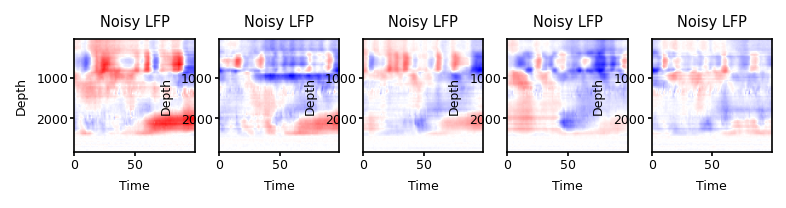

In [81]:
plot_trial = 0

plt.figure(figsize=(6, 1), dpi=150)

ax = plt.subplot(151)
plt.subplot(151)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')

plt.subplot(152)
plt.imshow(lfp[:,:,plot_trial+1], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')

plt.subplot(153)
plt.imshow(lfp[:,:,plot_trial+2], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')

plt.subplot(154)
plt.imshow(lfp[:,:,plot_trial+3], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')

plt.subplot(155)
plt.imshow(lfp[:,:,plot_trial+4], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')

In [255]:
V1['intervals'], V1['structure_acronyms']

(array([ 0,  3,  9, 20, 38, 48, 61, 85, 93]),
 array(['MGm', 'SGN', 'LP', 'DG', 'ProS', 'SUB', 'VISp', nan], dtype=object))

In [256]:
V1['locationA'][20], V1['locationA'][61]

(array([840,  59]), array([2480,   59]))

In [147]:
### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp)

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
gpcsd.fit(n_restarts=10)
# gpcsd.R['value'] = 150
# gpcsd.spatial_cov.params['ell']['value'] = 200
gpcsd.predict(z, t)
gpcsd_pred = gpcsd.csd_pred

gpcsd_hp = gpcsd.extract_model_params()
rep = 10
gpcsd_errors = []
del_electrode_list = np.random.choice(range(1, nx-1), rep, replace=False)
A = b_fwd_1d(z.T-x, gpcsd.R['value'])
for del_electrode in tqdm(del_electrode_list):
    x_temp = np.delete(x, del_electrode, axis=0)
    Y_temp = np.delete(lfp, del_electrode, axis=0)
    gpcsd = GPCSD1D(Y_temp, x_temp, t)
    # gpcsd.restore_model_params(gpcsd_hp)
    gpcsd.fit(n_restarts=10)
    gpcsd.predict(z, t)
    csd_temp = gpcsd.csd_pred
    lfp_pred = np.einsum('xz,ztm->xtm', A, csd_temp)
    gpcsd_errors.append(np.mean((normalize(lfp[del_electrode, :, :]) - normalize(lfp_pred[del_electrode, :, :]) )**2))

### kCSD
lfp_flattened = lfp.reshape(lfp.shape[0], -1)
kcsd = KCSD1D(x, lfp_flattened, gdx=(z[1]-z[0]))
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd_pred = kcsd.values().reshape((nz, nt, ntrial))

kcsd_hp = [kcsd.R, kcsd.lambd]
rep = 10
kcsd_errors = []
del_electrode_list = np.random.choice(range(1, nx-1), rep, replace=False)
A = b_fwd_1d(z.T-x, kcsd.R)
for del_electrode in tqdm(del_electrode_list):
    x_temp = np.delete(x, del_electrode, axis=0)
    Y_temp = np.delete(lfp_flattened, del_electrode, axis=0)
    kcsd = KCSD1D(x_temp, Y_temp, gdx=(z[1]-z[0]))
    # kcsd.R, kcsd.lambd = kcsd_hp
    kcsd.cross_validate(Rs=np.linspace(100, 800, 10), lambdas=np.logspace(4,-15,15,base=10.))
    csd_temp = kcsd.values().reshape((nz, nt, ntrial))
    lfp_pred = np.einsum('xz,ztm->xtm', A, csd_temp)
    kcsd_errors.append(np.mean((normalize(lfp[del_electrode, :, :]) - normalize(lfp_pred[del_electrode, :, :]) )**2))

### rCSD
R_true = 150
lam_smooth = 1
lam_region = 1e-2
lam_lasso = 0.3e-1
rcsd = rCSD.rCSD(lfp, z, x, boundary_depth=[860, 2500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict(parallel=False)
# rcsd.get_difference()


Restarts:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:18<00:00, 13.85s/it]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 150.0 5.108969774506935e-07


  0%|          | 0/10 [00:00<?, ?it/s]

Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 10%|█         | 1/10 [00:03<00:30,  3.43s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 20%|██        | 2/10 [00:06<00:27,  3.41s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 30%|███       | 3/10 [00:09<00:23,  3.30s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 40%|████      | 4/10 [00:13<00:20,  3.34s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 50%|█████     | 5/10 [00:16<00:16,  3.28s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 60%|██████    | 6/10 [00:19<00:13,  3.32s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 70%|███████   | 7/10 [00:23<00:09,  3.31s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 80%|████████  | 8/10 [00:26<00:06,  3.25s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


 90%|█████████ | 9/10 [00:29<00:03,  3.32s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07
Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 177.77777777777777
Cross validating R (all lambda) : 255.55555555555554
Cross validating R (all lambda) : 333.3333333333333
Cross validating R (all lambda) : 411.1111111111111
Cross validating R (all lambda) : 488.88888888888886
Cross validating R (all lambda) : 566.6666666666666
Cross validating R (all lambda) : 644.4444444444443
Cross validating R (all lambda) : 722.2222222222222
Cross validating R (all lambda) : 800.0


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]

R, lambda : 177.77777777777777 1.389495494373136e-07


In [148]:
np.mean(kcsd_errors), np.mean(gpcsd_errors)

(0.0313399879822938, 0.06544059302976268)

In [149]:
rcsd.cv_electrode()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:17<00:00, 13.74s/it]


0.005542212022650065

In [112]:
dic = rcsd.get_hp_dic()
rcsd.cv_para("R", [50, 100, 200], dic)

100%|██████████| 3/3 [06:32<00:00, 130.88s/it]


([0.002968233994210923, 0.00916925282702601, 0.0027936651391279595],
 [2.9572756990156037e-06, 8.779839490928737e-05, 1.5272182110509563e-06])

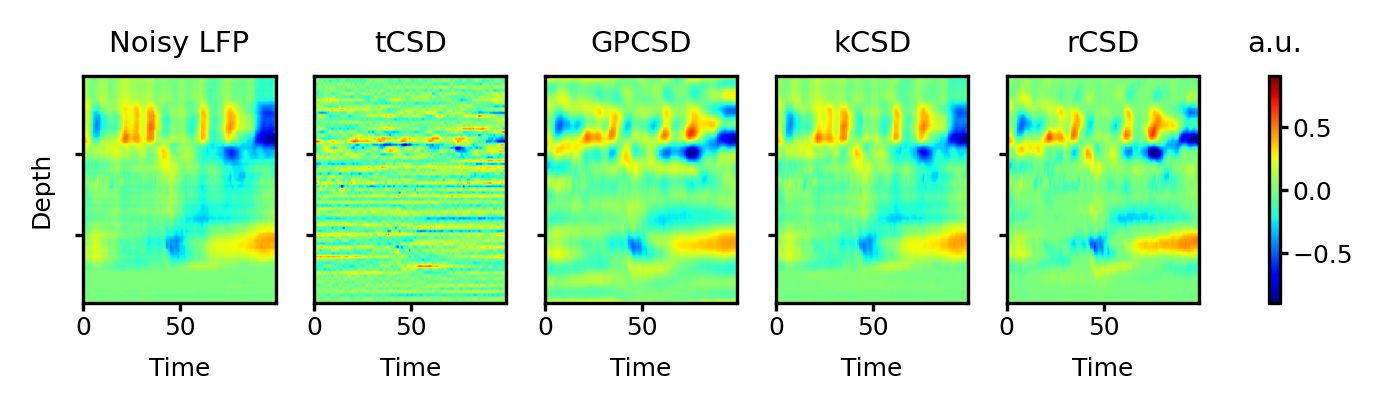

In [99]:
# %% Visualize results

plot_trial = 2
cmap = 'jet'
vmlfp = np.amax(np.abs(lfp))
vmcsd = np.amax(np.abs(normalize(gpcsd.csd_pred[:,:,plot_trial])))

f = plt.figure(figsize=(6, 1), dpi=300)

ax = plt.subplot(151)
plt.subplot(151)
plt.imshow(lfp[:,:,plot_trial], aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')
axtmp = plt.subplot(152, sharey = ax)
axtmp.set_yticklabels([])

plt.subplot(152, sharey = ax)
plt.imshow(normalize(tcsd[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time')

plt.subplot(153, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred[:,:,plot_trial]), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time')

plt.subplot(154, sharey = ax)
im = plt.imshow(normalize(kcsd[:,:,plot_trial]), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('kCSD')
plt.xlabel('Time')

plt.subplot(155, sharey = ax)
im = plt.imshow(normalize(rcsd_pred[:,:,plot_trial]), aspect='auto', 
                vmin=-0.9, vmax=0.9, cmap=cmap, extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')


clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()

